# LSTM on Quarterly Asset Pricing Data

## 1. Data Preparation

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
## conda install -c conda-forge keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# load dataset
dataset = pd.read_csv('./data.csv', header=0, index_col=0)
dataset = dataset[["PRIVATE.EQUITY", "REAL.ESTATE", "BUYOUT", "VENTURE", "Private.Capital...Europe"]]
# Venture is from the assets of lower growth, and private capital in euro is the highest growth
# Private equity, real estate and buyout are the client recommended
values = dataset.values

In [4]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# ensure all data is float and turn it from monthly to quarterly
values = values[::3].astype('float32')
# predict the present using the data 1 quarter before
n_quarters = 1
n_features = scaled.shape[1]

# frame as supervised learning
reframed = series_to_supervised(scaled, n_quarters, 1)

## 2. Define and Fit Mode

In [5]:
# split into train and test sets
values = reframed.values
train = values[:60, :]
test = values[12:, :]
# split into input and outputs
train_X, train_y = train[:, :n_features*n_quarters], train[:, -1]
test_X, test_y = test[:, :n_features*n_quarters], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_quarters, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], n_quarters, test_X.shape[1]))

## 3. Design and Fit Network

Train on 60 samples, validate on 203 samples
Epoch 1/300
 - 2s - loss: 0.0565 - val_loss: 0.3718
Epoch 2/300
 - 0s - loss: 0.0521 - val_loss: 0.3634
Epoch 3/300
 - 0s - loss: 0.0482 - val_loss: 0.3553
Epoch 4/300
 - 0s - loss: 0.0461 - val_loss: 0.3480
Epoch 5/300
 - 0s - loss: 0.0444 - val_loss: 0.3410
Epoch 6/300
 - 0s - loss: 0.0426 - val_loss: 0.3344
Epoch 7/300
 - 0s - loss: 0.0410 - val_loss: 0.3281
Epoch 8/300
 - 0s - loss: 0.0397 - val_loss: 0.3222
Epoch 9/300
 - 0s - loss: 0.0387 - val_loss: 0.3167
Epoch 10/300
 - 0s - loss: 0.0380 - val_loss: 0.3116
Epoch 11/300
 - 0s - loss: 0.0373 - val_loss: 0.3067
Epoch 12/300
 - 0s - loss: 0.0366 - val_loss: 0.3021
Epoch 13/300
 - 0s - loss: 0.0361 - val_loss: 0.2978
Epoch 14/300
 - 0s - loss: 0.0355 - val_loss: 0.2937
Epoch 15/300
 - 0s - loss: 0.0349 - val_loss: 0.2899
Epoch 16/300
 - 0s - loss: 0.0344 - val_loss: 0.2864
Epoch 17/300
 - 0s - loss: 0.0339 - val_loss: 0.2831
Epoch 18/300
 - 0s - loss: 0.0333 - val_loss: 0.2799
Epoch 19/3

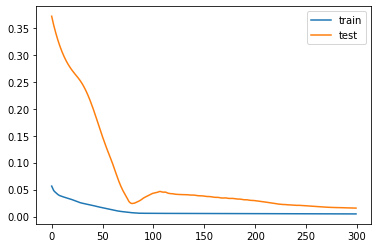

In [6]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=1200, validation_data=(test_X, test_y) , verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## 4. Prediction and Evaluation

### Test

In [7]:
# prediction
yhat=model.predict(test_X)
test_X=test_X.reshape((test_X.shape[0], n_quarters*n_features))

In [8]:
# invert scaling for forecast
inv_yhat0 = concatenate((test_X[:, -n_features:-1], yhat), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat0)
inv_yhat = inv_yhat1[:,-1]

In [9]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y0 = concatenate((test_X[:, -n_features:-1],test_y), axis=1)
inv_y1 = scaler.inverse_transform(inv_y0)
inv_y = inv_y1[:,-1]

In [10]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 16.789


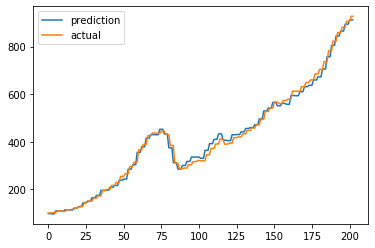

In [11]:
# x-aixs: time (from newest to oldest). y-axis: asset return 
pyplot.plot(inv_y, label='prediction')
pyplot.plot(inv_yhat, label='actual')
pyplot.legend()
pyplot.show()

### Train

In [12]:
# prediction
yhat=model.predict(train_X)
train_X=train_X.reshape((train_X.shape[0], n_quarters*n_features))

In [13]:
# inverst scaling for forecast
inv_yhat0 = concatenate((train_X[:, -n_features:-1], yhat), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat0)
inv_yhat = inv_yhat1[:,-1]

In [14]:
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y0 = concatenate((train_X[:, -n_features:-1],train_y), axis=1)
inv_y1 = scaler.inverse_transform(inv_y0)
inv_y = inv_y1[:,-1]

In [15]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Train RMSE: %.3f' % rmse)

Train RMSE: 5.911


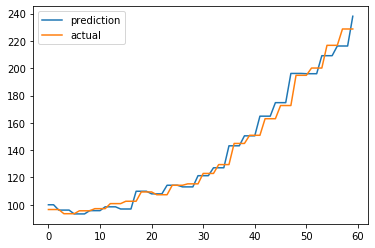

In [16]:
# x-aixs: time (from newest to oldest). y-axis: asset return 
pyplot.plot(inv_y, label='prediction')
pyplot.plot(inv_yhat, label='actual')
pyplot.legend()
pyplot.show()